# upscaling when the thickness changes

In [1]:
import numpy as np
import os
import scipy.sparse as sp
import pandas as pd
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
import pickle
from multiprocessing import Pool
from sklearn import linear_model

# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg import(
    maps, Report, data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils
)
from pymatsolver import Pardiso

from utils import pad_for_casing_and_data

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [3]:
directory_path = "/t40array/lheagy/casing-upscaling-permeable-vary-thickness"

In [4]:
def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

# Example usage
ensure_directory_exists(directory_path)

Directory '/t40array/lheagy/casing-upscaling-permeable-vary-thickness' already exists.


In [5]:
save_figures = False
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [6]:
# # conductivities
sigma_air = 1e-4
sigma_back = 1e-1
casing_l = 500
sigma_casing = 5e6
mur_casing = np.r_[1, 10, 25, 50, 100, 150, 200]

# # casing geometry
casing_b = 5e-2  
casing_t = np.r_[5e-3, 1e-2, 1.5e-2, 2e-2, 2.5e-2, 3e-2]  #np.r_[5e-3, 7.5e-3, 10e-3, 12.5e-3, 15e-3, 20e-3]
casing_a = casing_b - casing_t

In [7]:
src_dz = 10
src_z = -515 #np.r_[-100, -250, -400, -495, -500, -550, -600]

In [8]:
# generate a mesh
hx = pad_for_casing_and_data(
   casing_outer_radius = casing_b,
    csx1 = casing_t.min()/8, 
    csx2 = 25, 
    pfx1 = 1.3,
    pfx2 = 1.5, 
    domain_x = 1000, 
    npadx = 10
)

pfz = 1.3
npad_z = 28
csz = 1
n_core_extra = 10
ncore_z = int(np.max(np.r_[np.abs(casing_l), np.abs(src_z)]) / csz) + n_core_extra
hz = discretize.utils.unpack_widths(
    [(csz, npad_z, -pfz), (csz, ncore_z), (csz, npad_z, pfz)]
)

<Axes: xlabel='x', ylabel='z'>

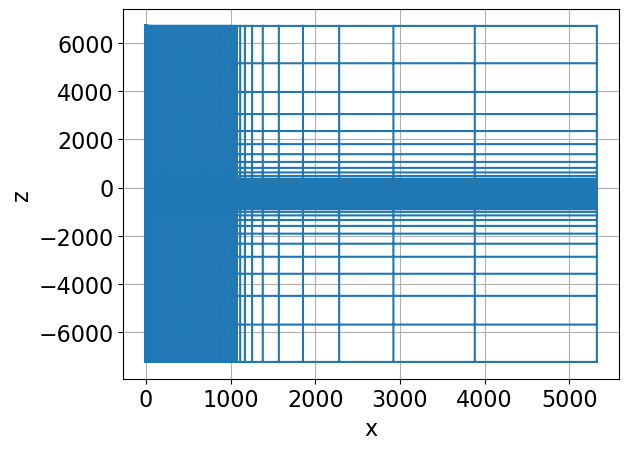

In [9]:
mesh = discretize.CylindricalMesh(
    [hx, np.r_[2*np.pi], hz], origin=np.r_[0, 0, -np.sum(hz[:npad_z + int(ncore_z)])],
)

fig, ax = plt.subplots(1, 1)
mesh.plot_grid(ax=ax)
# ax.set_xlim([0, 5])
# ax.set_ylim(-50, 10)

In [10]:
mesh.n_cells

99932

In [11]:
def get_physical_property_model(mesh, casing_a, casing_b, casing_l, sigma_back, sigma_casing, sigma_air=1e-4, mur_casing=1):

    model = np.ones(mesh.n_cells)*sigma_air
    model[mesh.cell_centers[:, 2] < 0] = sigma_back

    mur = np.ones(mesh.n_cells)

    inds_casing_x = (
        (mesh.cell_centers[:, 0] > casing_a) & 
        (mesh.cell_centers[:, 0] < casing_b)
    )
    inds_casing_z = (
        (mesh.cell_centers[:, 2] < 0) &
        (mesh.cell_centers[:, 2] > -casing_l)
    )
    inds_casing = inds_casing_x & inds_casing_z

    model[inds_casing] = sigma_casing
    mur[inds_casing] = mur_casing

    return model, mur

    

In [12]:
models = {}
for t in casing_t: 
    for mur in mur_casing:
        key = f"casing_mur{mur:1.0f}_t{t:1.1e}"
        sig_model, mur_model = get_physical_property_model(mesh, casing_b - t, casing_b, casing_l, sigma_back, sigma_casing, mur_casing=mur)
        models[key] = {
            "sigma": sig_model, 
            "mur": mur_model
        }
keys = list(models.keys())

In [13]:
keys

['casing_mur1_t5.0e-03',
 'casing_mur10_t5.0e-03',
 'casing_mur25_t5.0e-03',
 'casing_mur50_t5.0e-03',
 'casing_mur100_t5.0e-03',
 'casing_mur150_t5.0e-03',
 'casing_mur200_t5.0e-03',
 'casing_mur1_t1.0e-02',
 'casing_mur10_t1.0e-02',
 'casing_mur25_t1.0e-02',
 'casing_mur50_t1.0e-02',
 'casing_mur100_t1.0e-02',
 'casing_mur150_t1.0e-02',
 'casing_mur200_t1.0e-02',
 'casing_mur1_t1.5e-02',
 'casing_mur10_t1.5e-02',
 'casing_mur25_t1.5e-02',
 'casing_mur50_t1.5e-02',
 'casing_mur100_t1.5e-02',
 'casing_mur150_t1.5e-02',
 'casing_mur200_t1.5e-02',
 'casing_mur1_t2.0e-02',
 'casing_mur10_t2.0e-02',
 'casing_mur25_t2.0e-02',
 'casing_mur50_t2.0e-02',
 'casing_mur100_t2.0e-02',
 'casing_mur150_t2.0e-02',
 'casing_mur200_t2.0e-02',
 'casing_mur1_t2.5e-02',
 'casing_mur10_t2.5e-02',
 'casing_mur25_t2.5e-02',
 'casing_mur50_t2.5e-02',
 'casing_mur100_t2.5e-02',
 'casing_mur150_t2.5e-02',
 'casing_mur200_t2.5e-02',
 'casing_mur1_t3.0e-02',
 'casing_mur10_t3.0e-02',
 'casing_mur25_t3.0e-02',
 'c

In [14]:
def plot_casing(model, xlim=None, zlim=None, vmin=None, vmax=None, ax=None, cb_label=None, logscale=True, show_cb=False): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1)
    if logscale is True: 
        pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax), "cmap":"Spectral_r"}
    else: 
        pcolor_opts={"norm":Normalize(vmin=vmin, vmax=vmax), "cmap":"Spectral_r"}
    out = mesh.plot_image(
        model, pcolor_opts=pcolor_opts, ax=ax, mirror=True
    )

    if show_cb is True: 
        cb = plt.colorbar(out[-1], shrink=0.5)
        cb.set_label(cb_label)

    if xlim is not None: 
        ax.set_xlim(xlim)
    if zlim is not None: 
        ax.set_ylim(zlim)

    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax, out

In [15]:
# fig, ax = plt.subplots(1, 2, figsize=(2*4.5, 6.5), dpi=dpi_high, sharey=True)

# xlim = 0.3*np.r_[-1, 1]
# zlim = np.r_[-590, 20]
# vmin = sigma_air
# vmax = sigma_casing

# sigma_map, mu_map = create_maps(key)

# _, out = plot_casing(models[key]["sigma"], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[0])
# _, out = plot_casing(sigma_map * np.r_[np.log(1e5)], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[1])
# # cb.set_label("conductivity (S/m)")

# for i, a in enumerate(ax): 
#     a.plot(np.r_[0, 0], src_z + src_dz/2 * np.r_[-1, 1], "-ok", ms=4)
#     a.text(0.01, src_z, "10m dipole", va="center", fontsize=14)
#     for sign in np.r_[-1, 1]: 
#         if i == 0: 
#             a.arrow(
#                 0, -casing_l+120, casing_a*sign, 0, length_includes_head=True, shape="full", width=1e-2,
#                 head_length=1e-2, head_width=10, color="k"
#             ) 
#             a.text(0, -casing_l+100, f"{casing_a*1e2*2:1.0f} cm", ha="center", fontsize=10)
#             a.text(0.06, -200, "$\sigma$: 5e6 S/m \n$\mu>\mu_0$", fontsize=14)
#         else: 
#             a.text(0.06, -200, "$\sigma$: ? \n$\mu:?$", fontsize=14)
        
#         a.arrow(
#             0, -casing_l+80, casing_b*sign, 0, length_includes_head=True, shape="full", width=1e-2,
#             head_length=1e-2, head_width=10, color="k"
#         )
#         a.text(0, -casing_l+55, f"{casing_b*1e2*2:1.0f} cm", ha="center", fontsize=10)
#         a.text(-0.29, zlim.min()+10, f"{(1./sigma_back[0]):1.0f} $\Omega$m", fontsize=14)

# ax[1].set_ylabel("")

# ax[0].set_title("(a) true cased well")
# ax[1].set_title("(b) solid cylinder")
    

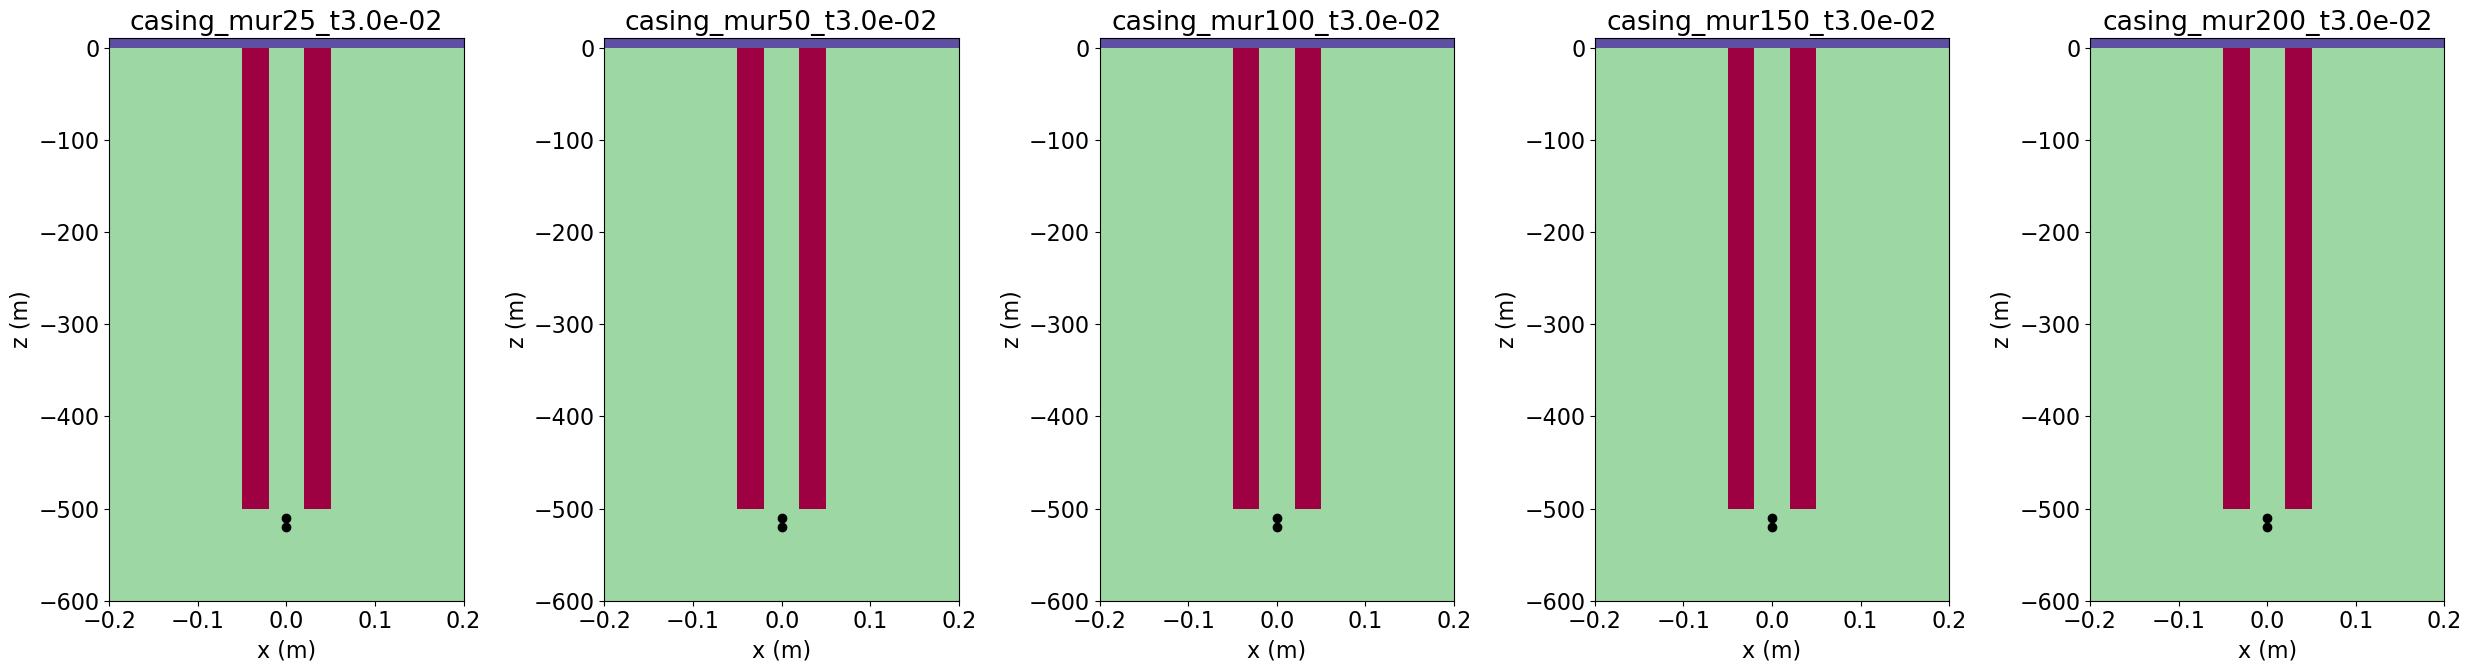

In [16]:
plot_keys = keys[-5:]
fig, ax = plt.subplots(1, len(plot_keys), figsize=(5*len(plot_keys), 7))

xlim = 0.2*np.r_[-1, 1]
zlim = np.r_[-600, 10]
vmin = sigma_air
vmax = np.max(sigma_casing)

for i, key in enumerate(plot_keys):
    plot_casing(models[key]["sigma"], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[i])
    ax[i].set_title(key)
    ax[i].plot(np.r_[0, 0], src_z + src_dz/2 * np.r_[-1, 1], "-ok")

plt.tight_layout()
# for loc in src_z:
#     ax.plot(np.r_[0, 0], loc + src_dz/2*np.r_[-1, 1], "-k", lw=4, alpha=0.5)

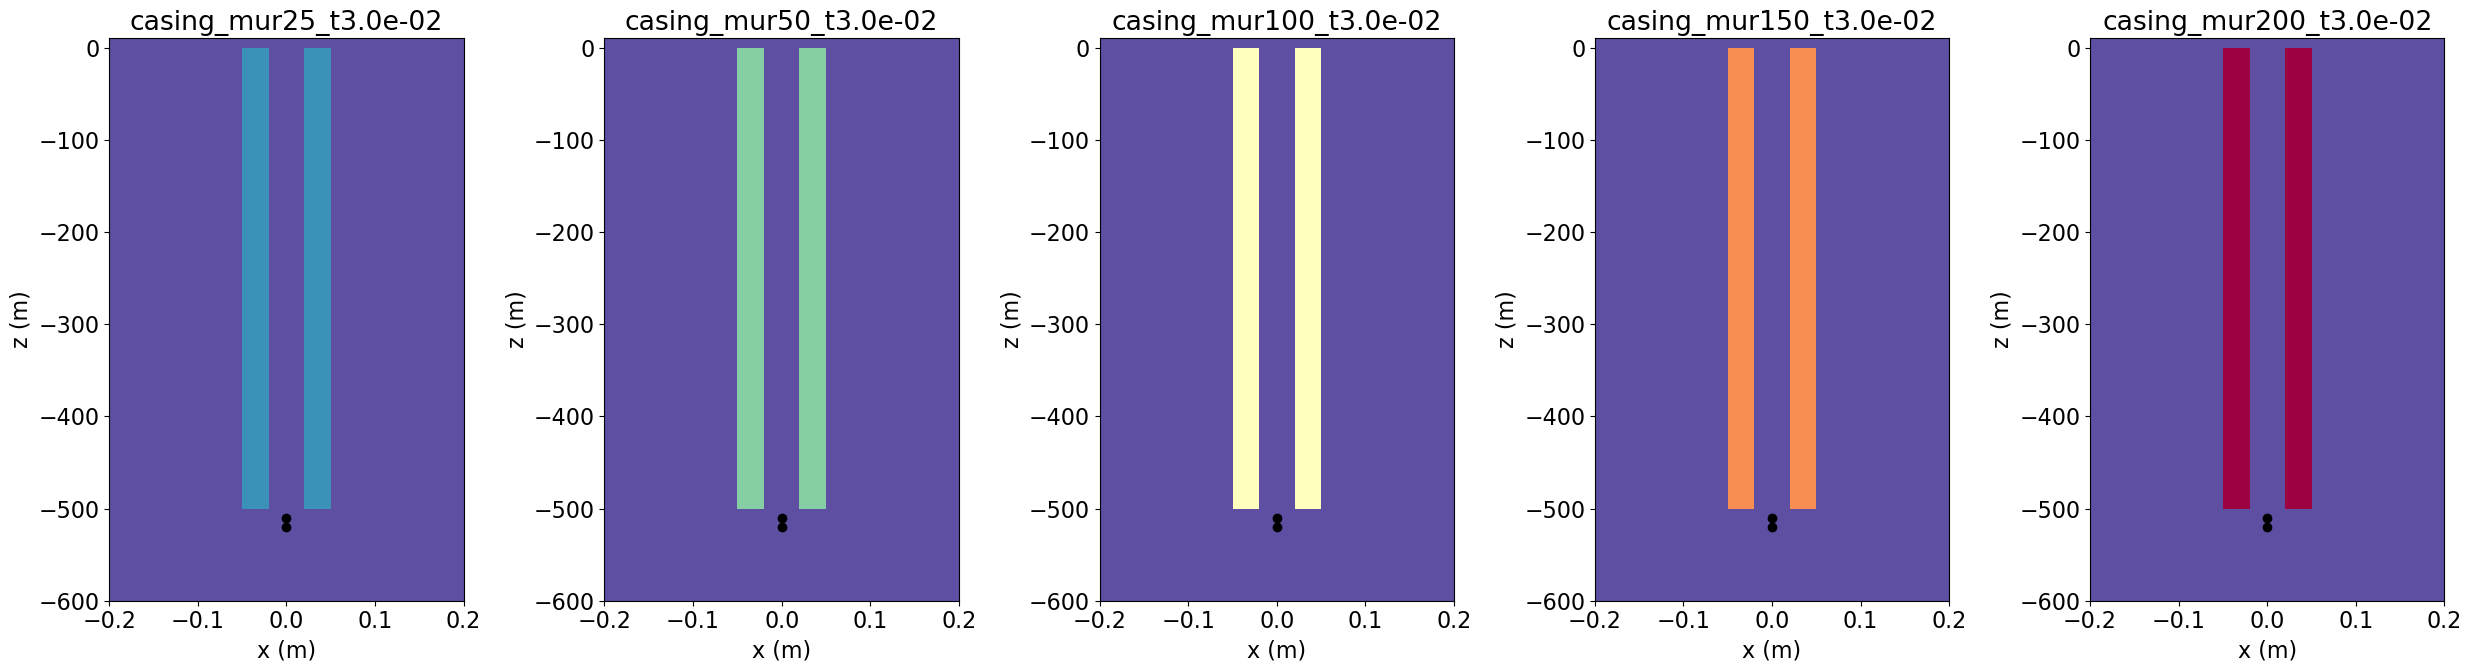

In [17]:
# plot_keys = keys
fig, ax = plt.subplots(1, len(plot_keys), figsize=(5*len(plot_keys), 7))

xlim = 0.2*np.r_[-1, 1]
zlim = np.r_[-600, 10]
vmin = 1
vmax = mur_casing.max()

for i, key in enumerate(plot_keys):
    plot_casing(models[key]["mur"], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[i], logscale=False)
    ax[i].set_title(key)
    ax[i].plot(np.r_[0, 0], src_z + src_dz/2 * np.r_[-1, 1], "-ok")

plt.tight_layout()
# for loc in src_z:
#     ax.plot(np.r_[0, 0], loc + src_dz/2*np.r_[-1, 1], "-k", lw=4, alpha=0.5)

## set up the simulations

In [18]:
frequencies = np.r_[1] #10**np.linspace(-1, 4, 36)
frequencies

array([1])

In [19]:
src_list = []
src_locations = np.array([
    [0, 0, src_z+src_dz/2.],
    [0, 0, src_z-src_dz/2.]
])
for f in frequencies: 
    src = fdem.sources.LineCurrent([], location=src_locations, frequency=f)
    src_list.append(src)

wires = maps.Wires(("sigma", mesh.n_cells), ("mur", mesh.n_cells))
permeability_map = maps.MuRelative(mesh)

survey = fdem.Survey(src_list)

sim = fdem.simulation.Simulation3DMagneticField(
    mesh=mesh, sigmaMap=wires.sigma, muMap=permeability_map * wires.mur,
    survey=survey, solver=Pardiso, #mu=mur * mu_0
#     verbose=True
)

In [20]:
def run_simulation(key):
    
    filename = os.path.sep.join([directory_path, key])

    t = time.time()
    print(f"starting {key}..., saving to {filename}")
    fields = sim.fields(np.r_[models[key]["sigma"], models[key]["mur"]])
    print(f" ... done. {time.time()-t:1.2e} \n")
    
    np.save(filename, fields[:, "hSolution"])

    return fields

In [21]:
fields = {}

In [22]:
for key in keys: 
    if key not in fields: 
        fields[key] = run_simulation(key)

starting casing_mur1_t5.0e-03..., saving to /t40array/lheagy/casing-upscaling-permeable-vary-thickness/casing_mur1_t5.0e-03
 ... done. 1.23e+00 

starting casing_mur10_t5.0e-03..., saving to /t40array/lheagy/casing-upscaling-permeable-vary-thickness/casing_mur10_t5.0e-03
 ... done. 5.21e-01 

starting casing_mur25_t5.0e-03..., saving to /t40array/lheagy/casing-upscaling-permeable-vary-thickness/casing_mur25_t5.0e-03
 ... done. 4.40e-01 

starting casing_mur50_t5.0e-03..., saving to /t40array/lheagy/casing-upscaling-permeable-vary-thickness/casing_mur50_t5.0e-03
 ... done. 4.08e-01 

starting casing_mur100_t5.0e-03..., saving to /t40array/lheagy/casing-upscaling-permeable-vary-thickness/casing_mur100_t5.0e-03
 ... done. 4.21e-01 

starting casing_mur150_t5.0e-03..., saving to /t40array/lheagy/casing-upscaling-permeable-vary-thickness/casing_mur150_t5.0e-03
 ... done. 3.96e-01 

starting casing_mur200_t5.0e-03..., saving to /t40array/lheagy/casing-upscaling-permeable-vary-thickness/casin

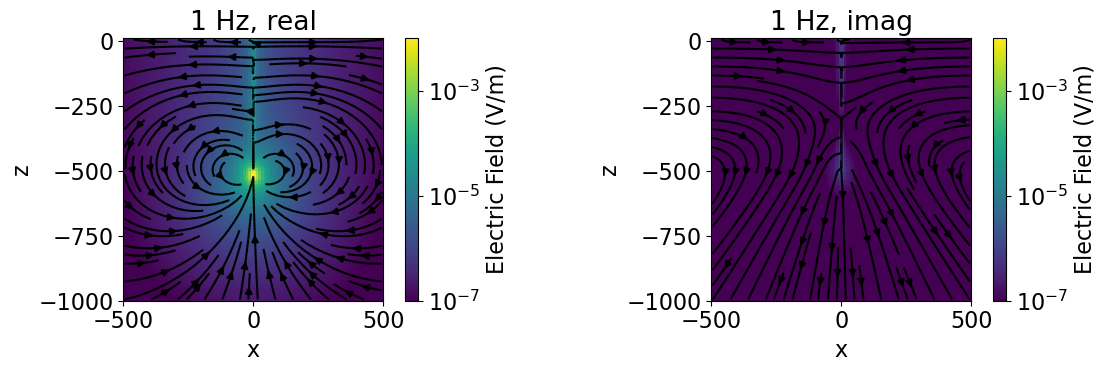

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

key = keys[0]
freq_ind = 0
xlim = 500*np.r_[-1, 1]
zlim = np.r_[-1000, 10]

field_plot = (mesh.average_face_to_cell_vector * fields[key][sim.survey.source_list[freq_ind], "e"])

for i, component in enumerate(["real", "imag"]): 
    out = mesh.plot_image(
        getattr(field_plot, component), "CCv", view="vec", 
        range_x = xlim, range_y = zlim,
        sample_grid = np.r_[10, 10],
        mirror=True, #mirror_data=field_mirror,
        ax=ax[i], 
        pcolor_opts={"norm":LogNorm(vmin=1e-7, vmax=1e-2)}
    )
    cb = plt.colorbar(out[0], ax=ax[i])
    cb.set_label("Electric Field (V/m)")
    ax[i].set_aspect(1)
    ax[i].set_title(f"{frequencies[freq_ind]} Hz, {component}")
plt.tight_layout()

In [24]:
rcParams["font.size"] = 12

In [25]:
fields.keys()

dict_keys(['casing_mur1_t5.0e-03', 'casing_mur10_t5.0e-03', 'casing_mur25_t5.0e-03', 'casing_mur50_t5.0e-03', 'casing_mur100_t5.0e-03', 'casing_mur150_t5.0e-03', 'casing_mur200_t5.0e-03', 'casing_mur1_t1.0e-02', 'casing_mur10_t1.0e-02', 'casing_mur25_t1.0e-02', 'casing_mur50_t1.0e-02', 'casing_mur100_t1.0e-02', 'casing_mur150_t1.0e-02', 'casing_mur200_t1.0e-02', 'casing_mur1_t1.5e-02', 'casing_mur10_t1.5e-02', 'casing_mur25_t1.5e-02', 'casing_mur50_t1.5e-02', 'casing_mur100_t1.5e-02', 'casing_mur150_t1.5e-02', 'casing_mur200_t1.5e-02', 'casing_mur1_t2.0e-02', 'casing_mur10_t2.0e-02', 'casing_mur25_t2.0e-02', 'casing_mur50_t2.0e-02', 'casing_mur100_t2.0e-02', 'casing_mur150_t2.0e-02', 'casing_mur200_t2.0e-02', 'casing_mur1_t2.5e-02', 'casing_mur10_t2.5e-02', 'casing_mur25_t2.5e-02', 'casing_mur50_t2.5e-02', 'casing_mur100_t2.5e-02', 'casing_mur150_t2.5e-02', 'casing_mur200_t2.5e-02', 'casing_mur1_t3.0e-02', 'casing_mur10_t3.0e-02', 'casing_mur25_t3.0e-02', 'casing_mur50_t3.0e-02', 'casi

In [26]:
def skin_depth(f, sigma, mur):
    return np.sqrt(2/(2*np.pi*f*sigma*mur*mu_0))

In [27]:
rx_x = np.linspace(25, 500, 20)
rx_z = -np.linspace(0, 600, 25) - csz/2
rx_z

array([-5.000e-01, -2.550e+01, -5.050e+01, -7.550e+01, -1.005e+02,
       -1.255e+02, -1.505e+02, -1.755e+02, -2.005e+02, -2.255e+02,
       -2.505e+02, -2.755e+02, -3.005e+02, -3.255e+02, -3.505e+02,
       -3.755e+02, -4.005e+02, -4.255e+02, -4.505e+02, -4.755e+02,
       -5.005e+02, -5.255e+02, -5.505e+02, -5.755e+02, -6.005e+02])

In [28]:
def create_receivers():
    rx_ex_re = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="real",
    )
    rx_ex_im = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="imag",
    )
    rx_ez_re = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="z",
        component="real",
    )
    rx_ez_im = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="z",
        component="imag",
    )
    return rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im

In [29]:
rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im = create_receivers()
Px = rx_ex_re.getP(mesh, "Fx")
Pz = rx_ez_re.getP(mesh, "Fz")

In [30]:
frequencies

array([1])

In [31]:
range(len(frequencies))

range(0, 1)

In [32]:
# get data_vectors
dobs_dict = {}

for k in keys:
    tmp_dict = {}
    for si in range(len(frequencies)):
        src = sim.survey.source_list[si]
        e = fields[k][src, "e"]
        edatax = (Px * e).squeeze()
        edataz = (Pz * e).squeeze()
        tmp_dict[frequencies[si]] = {
            "real_x": edatax.real,
            "imag_x": edatax.imag,
            "real_z": edataz.real,
            "imag_z": edataz.imag
        }
    dobs_dict[k] = tmp_dict
        

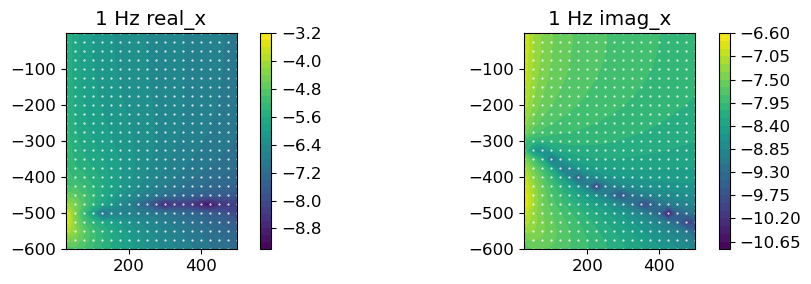

In [33]:
fig, ax = plt.subplots(len(frequencies), 2, figsize=(10, len(frequencies)*3), sharex=True)

key_ind = 0
key = keys[key_ind]

ax = np.atleast_2d(ax)
for i, freq in enumerate(frequencies): 
    # ax.plot(rx_x, dobs_dict[key][freq]["real"].reshape((len(rx_x), len(rx_z)), order="F"), "o" );
    for j, component in enumerate(["real_x", "imag_x"]): 
        plt.colorbar(
            ax[i, j].contourf(
                rx_x, rx_z, np.log10(np.abs(dobs_dict[key][freq][component].reshape((len(rx_x), len(rx_z)), order="F").T)), 30,
                # vmin=-7, vmax=-2
                # norm=LogNorm()
            ), ax=ax[i, j]
        )
        
        ax[i, j].plot(rx_ex_re.locations[:, 0], rx_ex_re.locations[:, 2], "w.", ms=1)
        ax[i, j].set_aspect(1)
        ax[i, j].set_title(f"{freq} Hz {component}")

plt.tight_layout()


In [34]:
def get_amplitude_phase(real, imag):
    # real = f.real
    # imag = f.imag
    amplitude = np.sqrt(real**2 + imag**2)
    phase = 180/np.pi*np.arctan2(imag, real)
    return amplitude, phase

In [35]:
# fig, ax = plt.subplots(len(frequencies), 2, figsize=(10, len(frequencies)*3), sharex=True)

# key_ind = 0
# key = keys[key_ind]

# for i, freq in enumerate(frequencies): 
#     amp, phase = get_amplitude_phase(*(dobs_dict[key][freq][component].reshape((len(rx_x), len(rx_z)), order="F").T for component in ["real", "imag"]))
#     for j, plotme in enumerate([np.log10(np.abs(amp)), phase]): 
#         plt.colorbar(
#             ax[i, j].contourf(
#                 rx_x, rx_z, plotme, 30,
#                 # vmin=-7, vmax=-2
#                 # norm=LogNorm()
#                 cmap = "twilight" if j == 1 else "viridis"
#             ), ax=ax[i, j]
#         )
        
#         ax[i, j].plot(rx_e_re.locations[:, 0], rx_e_re.locations[:, 2], "w.", ms=1)
#         ax[i, j].set_aspect(1)
#         ax[i, j].set_title(f"{freq} Hz {'amplitude' if j==0 else 'phase'}")

# plt.tight_layout()


# set up mappings and simulation

In [36]:
def create_maps(key, true_inds=False, casing_t_ind=0):
    indsx = (mesh.cell_centers[:, 0] < casing_b)
    if true_inds is True: 
        indsx = indsx & (mesh.cell_centers[:, 0] > casing_b - casing_t[casing_t_ind])
    
    inds_interior = (
        indsx &
        (mesh.cell_centers[:, 2] <= 0) &
        (mesh.cell_centers[:, 2] >= -casing_l)
    )

    active_inds_sigma = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=np.log(models[key]["sigma"][~inds_interior])
    )

    active_inds_mur = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=models[key]["mur"][~inds_interior]
    )

    projection_sigma = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])
    projection_mu = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])

    exp_map = maps.ExpMap(mesh)
    mur_map = maps.MuRelative(mesh)

    sigma_map = exp_map * active_inds_sigma * projection_sigma
    mu_map = mur_map * active_inds_mur * projection_mu

    return sigma_map, mu_map

In [37]:
src_locations

array([[   0.,    0., -510.],
       [   0.,    0., -520.]])

In [38]:
def create_survey(freq, components=["x"]): 
    rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im = create_receivers()
    rx_list = []
    if "x" in components: 
        rx_list.append([rx_ex_re, rx_ex_im])
    if "z" in components: 
        rx_list.append([rx_ez_re, rx_ez_im])
    src = fdem.sources.LineCurrent(list(np.hstack(rx_list)), location=src_locations, frequency=freq)
    return fdem.Survey([src])

In [39]:
# create the simulation
def create_simulation(key, survey, invert_mu=False, true_inds=False):
    sigma_map, mu_map = create_maps(key, true_inds)

    if invert_mu is True: 
        wires = maps.Wires(("sigma", 1), ("mu", 1))
        sim = fdem.simulation.Simulation3DMagneticField(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map * wires.sigma,
            muMap=mu_map * wires.mu 
        )
    else: 
        sim = fdem.simulation.Simulation3DMagneticField(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map
        )
    return sim


In [40]:
def get_casing_thickness_ind_by_key(key): 
    i = np.where([key == kk for kk in keys])[0]
    return np.int64(np.floor(i/(len(mur_casing))))

def get_mur_ind_by_key(key): 
    i = np.where([key == kk for kk in keys])[0]
    return np.mod(i, len(casing_t))

In [41]:
i = 0
print(keys[i])
j, k = get_casing_thickness_ind_by_key(keys[i]), get_mur_ind_by_key(keys[i])
print(casing_t[j], mur_casing[k])

casing_mur1_t5.0e-03
[0.005] [1]


In [42]:
t = casing_t
sigdc = sigma_casing * (1-(casing_b-t)**2/casing_b**2)

data0 = {}
res0 = {}
rms0 = {}

components = ["x", "z"]

for i, key in enumerate(keys): 
    data_tmp = {}
    res_tmp = {}
    rms_tmp = {}
    
    for freq in frequencies: 
        survey = create_survey(freq, components)
    
        receivers = []
        if "x" in components: 
            receivers.append(["real_x", "imag_x"])
        if "z" in components: 
            receivers.append(["real_z", "imag_z"])
        dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    
        sim = create_simulation(key, survey, invert_mu=False)

        ii = get_casing_thickness_ind_by_key(key)
        dpred = sim.dpred(np.log(sigdc[ii]))

        data_tmp[freq] = dpred
        res_tmp[freq] = dpred - dobsvec
        rms_tmp[freq] = np.sqrt(np.sum(res_tmp[freq]**2) / len(res_tmp[freq]))
    data0[key] = data_tmp
    res0[key] = res_tmp
    rms0[key] = rms_tmp

In [43]:
plot_inds = [2, 3, 4, 5, 6]

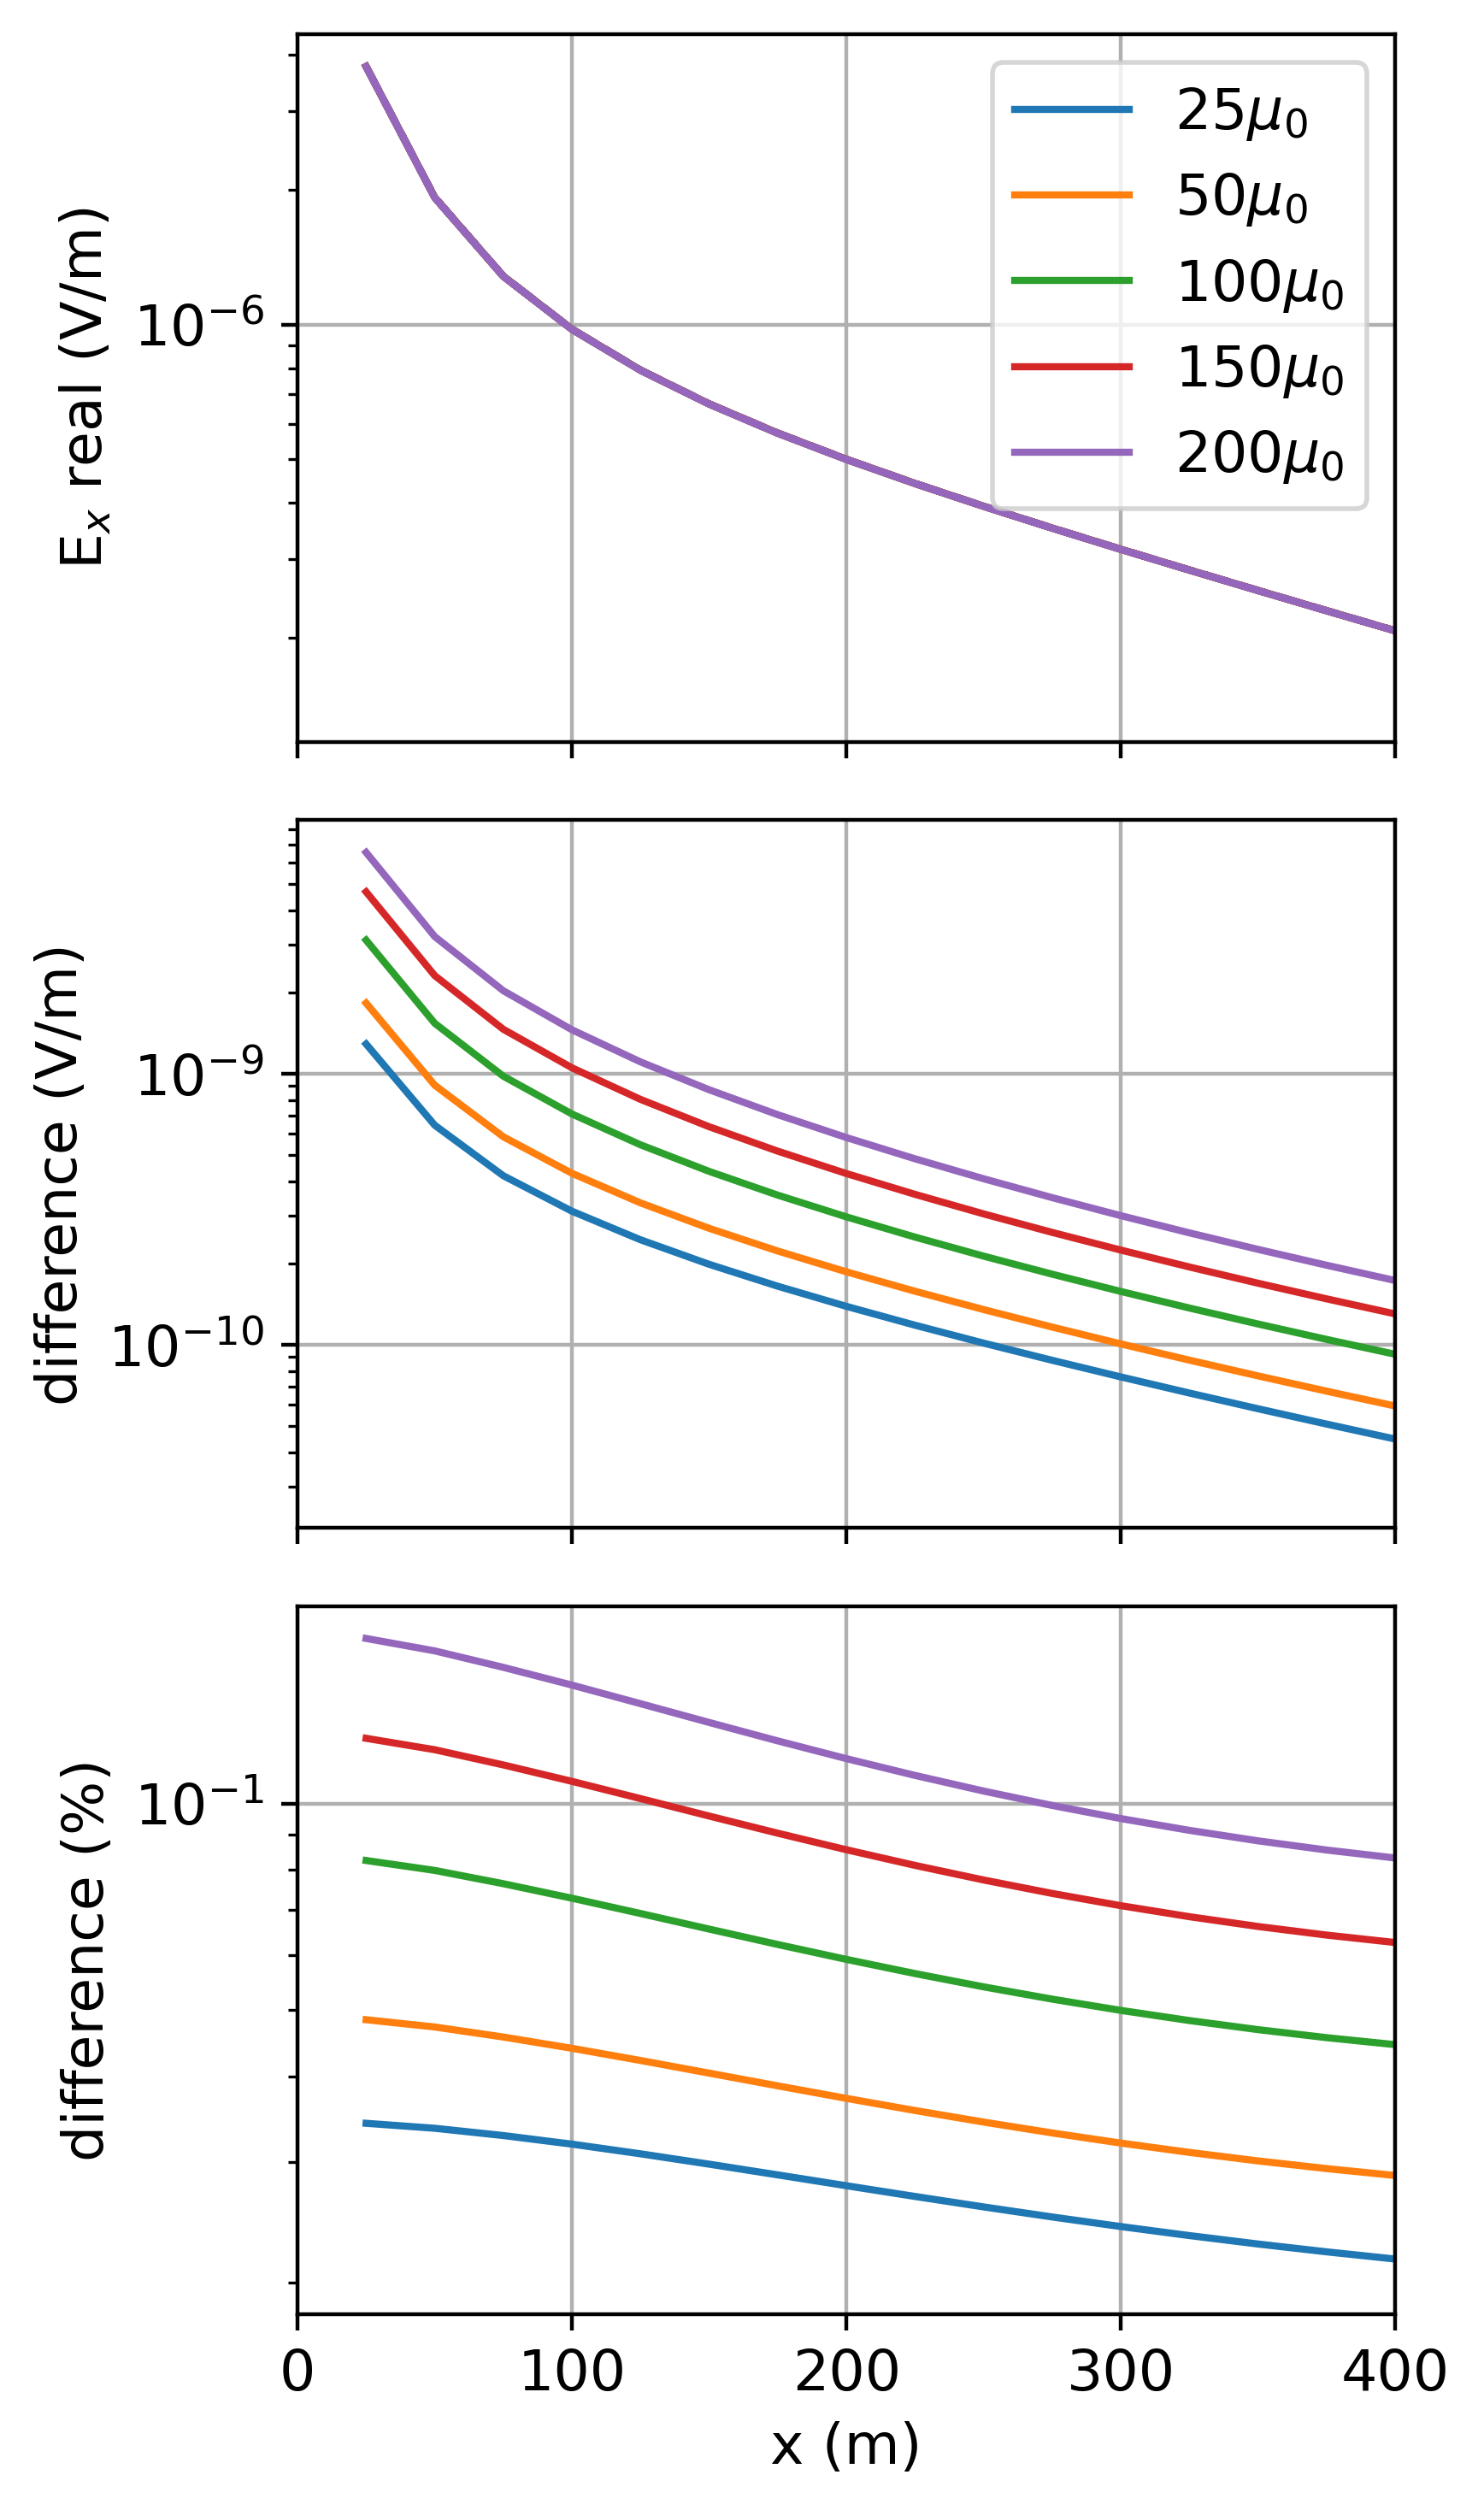

In [44]:
# freqs = frequencies[[7, 12, 14]]
freqs = frequencies[[0]]
fig, ax = plt.subplots(3, len(freqs), figsize=(4.5*len(freqs), 7.5), sharex=True, dpi=dpi_high)
ax=np.atleast_2d(ax).T
for j, freq in enumerate(freqs):
    plotind = 0
    for i, key in enumerate(keys): 
        if i in plot_inds:
            if i == 0:
                color = "k"
            else: 
                color = f"C{plotind}"
                plotind = plotind + 1
            dobs = dobs_dict[key][freq]["real_x"][:len(rx_x)]
            d0 = data0[key][freq][:len(rx_x)]
            ax[0, j].semilogy(rx_x, (dobs), color=color, label=f"{mur_casing[i]:1.0f}$\mu_0$")
            ax[0, j].semilogy(rx_x, (d0), f"--{color}")
            ax[1, j].semilogy(rx_x, np.abs(d0-dobs), color)
            ax[2, j].semilogy(rx_x, np.abs(d0-dobs)/np.abs(dobs)*100, color)
    
            # ax[0, j].set_title(f"{freq:1.0f} Hz\n({ascii_lowercase[j]})")
    
            # ax[0, j].set_ylim([2e-7, 5e-6])
            # ax[1, j].set_ylim([3e-10, 1e-6])
            # ax[2, j].set_ylim([5e-2, 1e2])

ax[0, 0].set_xlim([0, 400])
ax[0, 0].set_ylabel("E$_x$ real (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")

ax[0, 0].legend(loc=1)

# ax[0, 0].set_title("(a) 2 Hz real E$_x$")
# ax[0, 1].set_title("(b) 10 Hz real E$_x$")

# ax[1, 0].set_title("(c) 2 Hz difference (cylinder - hollow)")
# ax[1, 1].set_title("(d) 10 Hz difference (cylinder - hollow)")

# ax[2, 0].set_title("(e) 2 Hz difference (%)")
# ax[2, 1].set_title("(f) 10 Hz difference (%)")

for k, a in enumerate(ax.flatten()):
    a.grid()
#     if k > 1: 
#         a.set_title(f"({ascii_lowercase[k]})")

for a in ax[2, :].flatten():
    a.set_xlabel("x (m)")

for a in ax[:, 1:].flatten():
    a.set_yticklabels("")
    

plt.tight_layout()

# set up inversions

In [45]:
class SaveInversionProgress(directives.InversionDirective):
    """
    A custom directive to save items of interest during the course of an inversion
    """
    
    results_file = None
    
    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results 
        self.inversion_results = {
            "iteration":[],
            "phi_d":[],
            "dpred":[],
            "logsigma":[],
            "mur":[],
            "residual":[],
            "rms":[],
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append 
        the new values to our dictionary
        """
        
        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        self.inversion_results["logsigma"].append(self.invProb.model[0])
        self.inversion_results["mur"].append(self.invProb.model[1])

        dobs = self.invProb._dmisfit.objfcts[0].data.dobs
        
        self.inversion_results["residual"].append((dobs - self.invProb.dpred))
        self.inversion_results["rms"].append(np.sqrt(np.sum(self.inversion_results["residual"][-1]**2)/len(dobs)))
        
        if self.results_file is not None: 
            with open(f"{self.results_file}", "wb") as fp:
                pickle.dump(self.inversion_results, fp)
        
        

In [46]:
def create_inversion(
    key, freq, invert_mu=False, relative_error=None, noise_floor=None,
    maxIter=10, maxIterCG=50, maxIterLS=10, true_casing_inds=False, components=["x"],
    chifact=0.5
):
    # create the simulation
    survey = create_survey(freq, components)

    receivers = []
    if "x" in components: 
        receivers.append(["real_x", "imag_x"])
    if "z" in components: 
        receivers.append(["real_z", "imag_z"])
    dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    dobs = data.Data(
        survey=survey, dobs=dobsvec, relative_error=relative_error, noise_floor=noise_floor
    )

    sim = create_simulation(key, survey, invert_mu, true_casing_inds)
    dmis = data_misfit.L2DataMisfit(data=dobs, simulation=sim)

    if invert_mu is True: 
        reg = regularization.Smallness(mesh=discretize.TensorMesh([2]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf, 1], 
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            # aggressive_stepping=True
            # tolF=1e-3, tolX=1e-3,
        )
    
    else: 
        reg = regularization.Smallness(mesh=discretize.TensorMesh([1]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, #lower=np.r_[-np.inf], 
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            # aggressive_stepping=True
            # tolF=1e-3, tolX=1e-3,
        )

    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=0)

    # directives
    target_misfit = directives.TargetMisfit(chifact=chifact)
    
    if true_casing_inds:
        filename_save = f"inv_{key}_{freq:1.0f}_true_casing.pkl"
    else: 
        filename_save = f"inv_{key}_{freq:1.0f}.pkl"
    inversion_progress = SaveInversionProgress(results_file=f"{directory_path}/{filename_save}")
    
    # inversion 
    inv = inversion.BaseInversion(inv_prob, [target_misfit, inversion_progress])
    
    return inv

# experiment 2: invert for solid cylinder conductivity, permeability 

In [47]:
models.keys()

dict_keys(['casing_mur1_t5.0e-03', 'casing_mur10_t5.0e-03', 'casing_mur25_t5.0e-03', 'casing_mur50_t5.0e-03', 'casing_mur100_t5.0e-03', 'casing_mur150_t5.0e-03', 'casing_mur200_t5.0e-03', 'casing_mur1_t1.0e-02', 'casing_mur10_t1.0e-02', 'casing_mur25_t1.0e-02', 'casing_mur50_t1.0e-02', 'casing_mur100_t1.0e-02', 'casing_mur150_t1.0e-02', 'casing_mur200_t1.0e-02', 'casing_mur1_t1.5e-02', 'casing_mur10_t1.5e-02', 'casing_mur25_t1.5e-02', 'casing_mur50_t1.5e-02', 'casing_mur100_t1.5e-02', 'casing_mur150_t1.5e-02', 'casing_mur200_t1.5e-02', 'casing_mur1_t2.0e-02', 'casing_mur10_t2.0e-02', 'casing_mur25_t2.0e-02', 'casing_mur50_t2.0e-02', 'casing_mur100_t2.0e-02', 'casing_mur150_t2.0e-02', 'casing_mur200_t2.0e-02', 'casing_mur1_t2.5e-02', 'casing_mur10_t2.5e-02', 'casing_mur25_t2.5e-02', 'casing_mur50_t2.5e-02', 'casing_mur100_t2.5e-02', 'casing_mur150_t2.5e-02', 'casing_mur200_t2.5e-02', 'casing_mur1_t3.0e-02', 'casing_mur10_t3.0e-02', 'casing_mur25_t3.0e-02', 'casing_mur50_t3.0e-02', 'casi

In [48]:
inv_dict = {}
relative_error = 0.005
noise_floor = 1e-8

for i, key in enumerate(keys):
    # if i == 0: 
    #     chifact = 0.5
    # else: 
    chifact = 1e-7
    if key not in inv_dict: 
        tmp = {}
        for freq in frequencies:
            
            tmp[freq] = create_inversion(
                    key, freq, invert_mu=True, relative_error=relative_error, noise_floor=noise_floor,
                    components=["x", "z"], chifact=chifact
                )
        inv_dict[key] = tmp

In [49]:
tmp = inv_dict[keys[0]][frequencies[0]]
np.unique(tmp.invProb.dmisfit.objfcts[0].simulation.muMap * np.r_[10, 1])

array([1.25663706e-06])

In [50]:
t = casing_t
sigdc = sigma_casing * (1-(casing_b-t)**2/casing_b**2)
# starting_models = {
#     True: np.r_[np.log(sigstart), 1],
#     False: np.r_[np.log(sigstart)]
# }

In [51]:
sigdc

array([ 950000., 1800000., 2550000., 3200000., 3750000., 4200000.])

In [52]:
mrec_dict = {}

for i, key in enumerate(keys):
    ti = get_casing_thickness_ind_by_key(key)
    mi = get_mur_ind_by_key(key)
    
    if key not in mrec_dict: 
        tmp = {}
        for j, freq in enumerate(frequencies):
            print(f"\n\n------------------------ {key} : {freq} Hz -------------------------- \n")
            # if i == 0: 
            
            mstart = np.r_[np.log(sigdc[ti]), 1] #mur_casing[mi]]
            # else: 
            #     mstart = mrec_dict[keys[0]][freq]
            tmp[freq] = inv_dict[key][freq].run(mstart)
            print(f"recovered conductivity: {np.exp(inv_dict[key][freq].m[0]):1.2e}, recovered permeability: {inv_dict[key][freq].m[1]:1.2f} mu0 \n")
        mrec_dict[key] = tmp



------------------------ casing_mur1_t5.0e-03 : 1 Hz -------------------------- 

simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DMagneticField problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  2.27e+00  0.00e+00  2.27e+00    2.07e+02      0              
   1  0.00e+00  2.18e+00  4.49e-07  2.18e+00    4.69e-02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 9.7985e-02 <= tolF*(1+|f0|) = 3.2734e-01
1 : |xc-x_last| = 9.4746e-04 <= tolX*(1+|x0|) = 1.4800e+00
1 : |proj(x-g)-x

In [53]:
inv_results = {}

for key in keys:
    if key not in inv_results: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = inv_dict[key][freq].directiveList.dList[1].inversion_results
        inv_results[key] = tmp

In [54]:
tmp = inv_results[keys[0]][frequencies[0]]

In [55]:
tmp = inv_dict[keys[0]][frequencies[0]]

In [56]:
phi_d_final = {}
chifact_final = {}
phid_star = len(rx_x)*len(rx_z)*2

for key in keys:
    phid_tmp = np.ones(len(frequencies)) * np.nan
    for i, freq in enumerate(frequencies): 
        phid = inv_results[key][freq]["phi_d"]
        if len(phid) > 0: 
            phid_tmp[i] = phid[-1]
    phi_d_final[key] = phid_tmp
    chifact_final[key] = phi_d_final[key] / phid_star

In [57]:
phid_min = {}
chifact_min = {}
logsig_min = {}
mur_min = {}
rms_min = {}

for key in keys:
    phid_tmp = np.ones(len(frequencies)) * np.nan
    logsig_tmp = np.ones(len(frequencies)) * np.nan
    mur_tmp = np.ones(len(frequencies)) * np.nan
    rms_tmp = np.ones(len(frequencies)) * np.nan
    for i, freq in enumerate(frequencies): 
        phid = inv_results[key][freq]["phi_d"]
        if len(phid) > 0: 
            ind_min = np.argmin(phid)
            phid_tmp[i] = phid[ind_min]
            logsig_tmp[i] = inv_results[key][freq]["logsigma"][ind_min]
            mur_tmp[i] = inv_results[key][freq]["mur"][ind_min]
            rms_tmp[i] = inv_results[key][freq]["rms"][ind_min]
    phid_min[key] = phid_tmp
    logsig_min[key] = logsig_tmp
    mur_min[key] = mur_tmp
    rms_min[key] = rms_tmp

In [58]:
np.hstack(mur_min.values())

/tmp/ipykernel_3754273/364635938.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  np.hstack(mur_min.values())


array([  1.        ,   1.34084747,   3.35130439,   6.70402681,
        13.4089896 ,  20.11604428,  26.82625524,   1.        ,
         2.65755898,   6.64530835,  13.29388752,  26.61437971,
        39.99005   ,  53.4499501 ,   1.        ,   3.95651684,
         9.8940212 ,  19.80814779,  39.78295071,  60.11528183,
        81.05471794,   1.        ,   5.21700984,  13.05150293,
        26.16869404,  52.90023915,  80.99247207, 112.05223779,
         1.        ,   6.4161804 ,  16.06013945,  32.26582334,
        65.86048699, 103.44097497, 155.76668327,   1.        ,
         7.52304322,  18.83940557,  37.91835682,  78.19987842,
       127.69059676, 217.12477997])

In [59]:
keys

['casing_mur1_t5.0e-03',
 'casing_mur10_t5.0e-03',
 'casing_mur25_t5.0e-03',
 'casing_mur50_t5.0e-03',
 'casing_mur100_t5.0e-03',
 'casing_mur150_t5.0e-03',
 'casing_mur200_t5.0e-03',
 'casing_mur1_t1.0e-02',
 'casing_mur10_t1.0e-02',
 'casing_mur25_t1.0e-02',
 'casing_mur50_t1.0e-02',
 'casing_mur100_t1.0e-02',
 'casing_mur150_t1.0e-02',
 'casing_mur200_t1.0e-02',
 'casing_mur1_t1.5e-02',
 'casing_mur10_t1.5e-02',
 'casing_mur25_t1.5e-02',
 'casing_mur50_t1.5e-02',
 'casing_mur100_t1.5e-02',
 'casing_mur150_t1.5e-02',
 'casing_mur200_t1.5e-02',
 'casing_mur1_t2.0e-02',
 'casing_mur10_t2.0e-02',
 'casing_mur25_t2.0e-02',
 'casing_mur50_t2.0e-02',
 'casing_mur100_t2.0e-02',
 'casing_mur150_t2.0e-02',
 'casing_mur200_t2.0e-02',
 'casing_mur1_t2.5e-02',
 'casing_mur10_t2.5e-02',
 'casing_mur25_t2.5e-02',
 'casing_mur50_t2.5e-02',
 'casing_mur100_t2.5e-02',
 'casing_mur150_t2.5e-02',
 'casing_mur200_t2.5e-02',
 'casing_mur1_t3.0e-02',
 'casing_mur10_t3.0e-02',
 'casing_mur25_t3.0e-02',
 'c

/tmp/ipykernel_3754273/2389818454.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  mur_min_vals = np.hstack(mur_min.values())
/tmp/ipykernel_3754273/2389818454.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dmis_vals = np.hstack(phid_min.values())
/tmp/ipykernel_3754273/2389818454.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  logsig_vals = np.hstack(logsig_min.values())


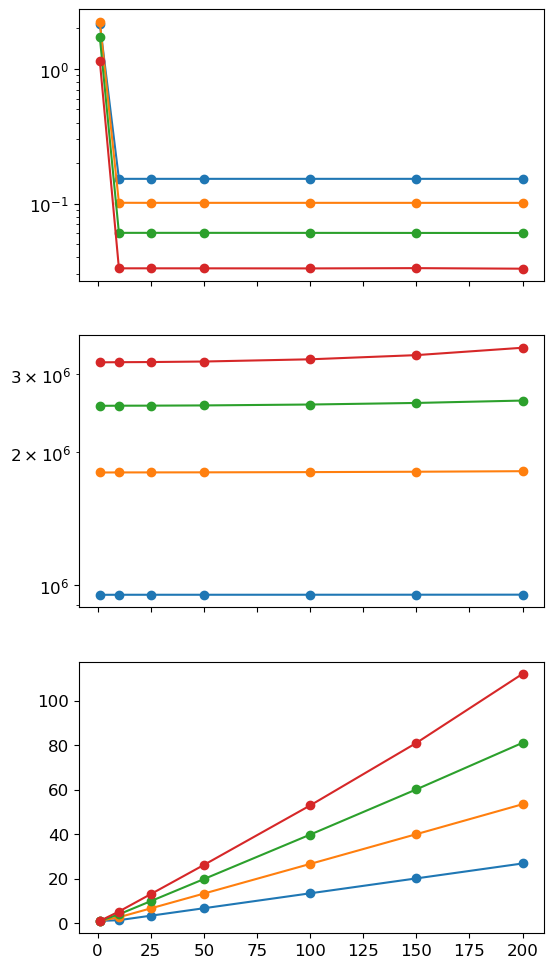

In [60]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6, 12))

n = len(mur_casing)
mur_min_vals = np.hstack(mur_min.values())
dmis_vals = np.hstack(phid_min.values())
logsig_vals = np.hstack(logsig_min.values())

for i, t in enumerate(casing_t[:-2]):
    ax[0].semilogy(mur_casing, dmis_vals[i*n:(i+1)*n], "-o", label=t)
    ax[1].semilogy(mur_casing, np.exp(logsig_vals[i*n:(i+1)*n]), "-o", label=t)
    ax[2].plot(mur_casing, mur_min_vals[i*n:(i+1)*n], "-o", label=t)

In [61]:
mur_slopes = np.zeros(len(casing_t))
mur_intercepts = np.zeros(len(casing_t))

chi_slopes = np.zeros(len(casing_t))
chi_intercepts = np.zeros(len(casing_t))


lr_mur = linear_model.LinearRegression()
lr_chi = linear_model.LinearRegression(fit_intercept=False)

for i, t in enumerate(casing_t):
    mur_t = mur_min_vals[i*n:(i+1)*n]
    
    lr_mur.fit(np.atleast_2d(mur_casing).T, mur_t)
    mur_slopes[i] = lr_mur.coef_
    mur_intercepts[i] = lr_mur.intercept_

    lr_chi.fit(np.atleast_2d(mur_casing-1).T, mur_t-1)
    chi_slopes[i] = lr_chi.coef_
    

In [62]:
casing_b

0.05

In [63]:
mur_slopes

array([0.13223992, 0.2655069 , 0.40293156, 0.55431453, 0.75471445,
       1.02215523])

In [64]:
chi_slopes*casing_b/casing_t

array([1.27981163, 1.30829262, 1.32779016, 1.36339094, 1.4579413 ,
       1.60334424])

In [65]:
casing_t

array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 ])

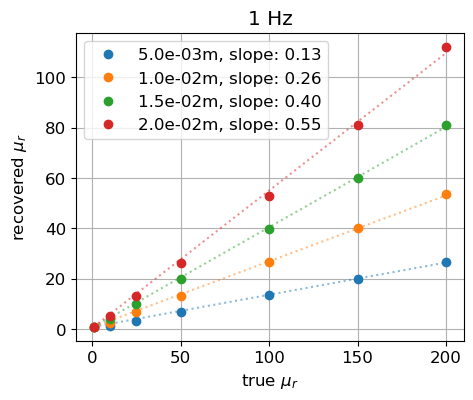

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

for i, t in enumerate(casing_t[:-2]):
    mur_t = mur_min_vals[i*n:(i+1)*n]
    ax.plot(mur_casing, mur_t, f"C{i}o", label=f"{t:1.1e}m, slope: {chi_slopes[i]:1.2f}")
    ax.plot(mur_casing, chi_slopes[i]*(mur_casing-1)+1, f":C{i}", alpha=0.5)
ax.set_xlabel("true $\mu_r$")
ax.set_ylabel("recovered $\mu_r$")
ax.set_title(f"{frequencies[freq_ind]} Hz")
ax.grid("both")
# ax.set_aspect(1)
ax.legend()
    # ax.plot()

In [67]:
slopes2, intercepts, r, p, std_err = stats.linregress(mur_casing, mur_t) 

NameError: name 'stats' is not defined

In [ ]:
intercepts

In [ ]:
plt.plot(casing_t[:-2], slopes[:-2], "ok")

In [ ]:
mur_casing_full = np.kron(np.ones(len(casing_t)), mur_casing)
casing_t_full = np.kron(casing_t, np.ones(len(mur_casing)))

In [ ]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression(fit_intercept=False)

In [ ]:
ind = len(mur_casing)*4
X = np.vstack([mur_casing_full[:ind], casing_t_full[:ind]]).T
y = mur_min_vals[:ind]
clf.fit(X, y)

In [ ]:
clf.coef_, clf.intercept_

In [ ]:
# fig, ax = plt.subplots(3, 1, figsize=(6, 12), sharex=True) 

# for key in keys: 
#     mrec = np.vstack(mrec_dict[key].values())
    
#     ax[0].semilogx(frequencies, phi_d_final[key] / phid_star, "o", label=key)
#     ax[0].semilogx(frequencies,  np.ones_like(frequencies),"--k")
#     ax[1].loglog(frequencies, np.exp(mrec[:, 0]), "o", label=key)
#     ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
#     ax[1].loglog(frequencies, np.ones_like(frequencies)*sigdc, "--k")
#     ax[2].semilogx(frequencies, mrec[:, 1], "o", label=key)

# ax[1].set_ylim([1e6, 1e8])
# # ax[0].legend()

In [ ]:
# fig, ax = plt.subplots(3, 1, figsize=(6, 12), sharex=True) 

# for key in keys: 
#     ax[0].loglog(frequencies, phid_min[key], "o", label=key)
#     ax[0].semilogx(frequencies, phid_star * np.ones_like(frequencies),"--k")
#     ax[1].loglog(frequencies, np.exp(logsig_min[key]), "o", label=key)
#     ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
#     ax[1].loglog(frequencies, np.ones_like(frequencies)*sigdc, "--k")
#     ax[2].semilogx(frequencies, (mur_min[key]), "o", label=key)
# ax[0].legend()

In [ ]:
markers = ["o", "v", "s", "D", "p", "^", "h"]

In [ ]:
mur_casing

In [ ]:
plotkeys = np.hstack([keys[0], keys[2:]])
plotkeys

In [ ]:
def mur_by_skindepth(delta):
    omega = 2 * np.pi * frequencies
    return 2 / (omega * delta**2 * sigma_casing) / mu_0

In [ ]:
mur_by_skindepth(casing_t)/mu_0

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6.75, 8.25), sharex=True, dpi=dpi_high) 

for i, key in enumerate(plotkeys): 
    color = "k" if i==0 else f"C{i-1}"
    label = f"{key.split('_')[-1][3:]} $\mu_0$"
    ax[0].loglog(frequencies, rms_min[key], f"-{markers[i]}", color=color, lw=0.75, ms=4, label=label)
    # ax[0].semilogx(frequencies, phid_star * np.ones_like(frequencies),"--k")
    ax[1].loglog(frequencies, np.exp(logsig_min[key]), f"-{markers[i]}", color=color, lw=0.75, ms=4, label=label)
    # ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
    # ax[1].loglog(frequencies, np.ones_like(frequencies)*sigdc, "--k")
    ax[2].loglog(frequencies, (mur_min[key]), f"-{markers[i]}", color=color, lw=0.75, ms=4, label=label)
    
for a in ax:
    a.grid()
    
ax[0].legend(loc=2)
ax[1].set_ylim(6e4, 2e7)
ax[2].set_ylim([0.7, 500])

ax[2].text(1.1e3, 2, "$\delta\sim t/2$", alpha=0.7)
ax[2].loglog(frequencies, mur_by_skindepth(casing_t/2), ":k", alpha=0.6)

# ax[2].text(7e1, 2, "$\delta\sim t$", alpha=0.7)
# ax[2].loglog(frequencies, mur_by_skindepth(casing_t), ":k", alpha=0.2)

ax[0].set_ylabel("RMS Misfit (V/m)")
ax[1].set_ylabel("Recovered $\sigma$ (S/m)")
ax[2].set_ylabel("Recovered $\mu_r$")
ax[2].set_xlabel("frequency (Hz)")

ax[0].set_title("(a)")
ax[1].set_title("(b)")
ax[2].set_title("(c)")

plt.tight_layout()

In [ ]:
skin_depths_casing = 500/np.sqrt(sigma_casing * frequencies) 

fig, ax = plt.subplots(1, 1) 
ax.loglog(frequencies, skin_depths_casing)
ax.loglog(frequencies, np.ones_like(frequencies)*casing_t, "--k")
ax.loglog(frequencies, np.ones_like(frequencies)*csz, ":k")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

freq_ind = 7

mur_1Hz =  np.array([mur_min[k][freq_ind] for k in plot_keys])
mur_true = np.array([np.float64(k.split('_')[-1][3:]) for k in plot_keys])

slope, intercept, r, p, std_err = stats.linregress(mur_true, mur_1Hz)

ax.plot(mur_true, mur_1Hz, "ko", label="recoverd $\mu_r$")
    
ax.plot(mur_true, slope*mur_true, ":k", alpha=0.5, label=f"slope: {slope:1.2f}")
ax.set_xlabel("true $\mu_r$")
ax.set_ylabel("recovered $\mu_r$")
ax.set_title(f"{frequencies[freq_ind]} Hz")
ax.grid("both")
# ax.set_aspect(1)
ax.legend()
    # ax.plot()

In [ ]:
casing_t

In [ ]:
casing_t/(casing_b)

In [ ]:
from scipy import stats

In [ ]:
slope

In [ ]:
intercept

In [ ]:
std_err